In [2]:
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_abc2f642b8b24a62b596c6fe7372f591 = ibm_boto3.client(service_name='****',
    ibm_api_key_id='****',
    ibm_auth_endpoint="https://iam.ng.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_abc2f642b8b24a62b596c6fe7372f591.get_object(Bucket='****',Key='****')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

# If you are reading an Excel file into a pandas DataFrame, replace `read_csv` by `read_excel` in the next statement.
df_311 = pd.read_csv(body)
df_311.head()


,created_date,unique_key,complaint_type,incident_zip,incident_address,street_name,address_type,city,resolution_description,borough,latitude,longitude,closed_date,location_type,status
0,2020-02-19T20:24:04.000,45649037,HEAT/HOT WATER,11209.0,9511 SHORE ROAD,SHORE ROAD,ADDRESS,BROOKLYN,The complaint you filed is a duplicate of a co...,BROOKLYN,40.616370,-74.038267,NaN,RESIDENTIAL BUILDING,Open
1,2020-02-19T08:47:18.000,45652275,HEAT/HOT WATER,10458.0,116 EAST MOSHOLU PARKWAY SOUTH,EAST MOSHOLU PARKWAY SOUTH,ADDRESS,BRONX,The complaint you filed is a duplicate of a co...,BRONX,40.876177,-73.883521,NaN,RESIDENTIAL BUILDING,Open
2,2020-02-19T15:21:09.000,45652211,DOOR/WINDOW,10453.0,1808 CEDAR AVENUE,CEDAR AVENUE,ADDRESS,BRONX,The following complaint conditions are still o...,BRONX,40.852653,-73.920212,NaN,RESIDENTIAL BUILDING,Open
3,2020-02-19T20:05:38.000,45652289,HEAT/HOT WATER,10034.0,252 SHERMAN AVENUE,SHERMAN AVENUE,ADDRESS,NEW YORK,The complaint you filed is a duplicate of a co...,MANHATTAN,40.866148,-73.919071,NaN,RESIDENTIAL BUILDING,Open
4,2020-02-19T20:53:12.000,45648600,HEAT/HOT WATER,10463.0,231 WEST 230 STREET,WEST 230 STREET,ADDRESS,BRONX,The following complaint conditions are still o...,BRONX,40.877587,-73.907309,NaN,RESIDENTIAL BUILDING,Open


Cleaning Data

In [3]:
df_311.dtypes

created_date               object
unique_key                  int64
complaint_type             object
incident_zip              float64
incident_address           object
street_name                object
address_type               object
city                       object
resolution_description     object
borough                    object
latitude                  float64
longitude                 float64
closed_date                object
location_type              object
status                     object
dtype: object

In [4]:
#Fixing the relvant data types for the given question
df_311['created_date'] = pd.to_datetime(df_311['created_date'])
df_311['closed_date'] = pd.to_datetime(df_311['closed_date'])
df_311['complaint_type'] = df_311['complaint_type'].astype('category')

In [5]:
#cleaning data with invalid complaint type or created date
df_311.dropna(subset=['complaint_type', 'created_date'], axis=0, inplace=True)
df_311.reset_index(drop=True, inplace=True)

In [6]:
#Since the question asks to consider complaints created till 31st Dec 2018, the dataset is modified accordingly
df_311 = df_311[df_311['created_date'] < pd.datetime(2019,1,1)]

Understanding the data

In [7]:
#Looking at number of complaints by complaint type
df_311['complaint_type'].value_counts()

HEAT/HOT WATER            1023788
HEATING                    887869
PLUMBING                   673406
GENERAL CONSTRUCTION       500863
UNSANITARY CONDITION       390908
PAINT - PLASTER            361257
PAINT/PLASTER              311076
ELECTRIC                   289345
NONCONST                   260890
DOOR/WINDOW                179573
WATER LEAK                 167900
GENERAL                    132207
FLOORING/STAIRS            122869
APPLIANCE                  101944
HPD Literature Request      51604
SAFETY                      44088
OUTSIDE BUILDING             6532
ELEVATOR                     5620
CONSTRUCTION                 5078
Unsanitary Condition          141
General                        70
STRUCTURAL                     16
AGENCY                          9
VACANT APARTMENT                8
Safety                          8
Mold                            0
Outside Building                0
Plumbing                        0
Electric                        0
Appliance     

In [8]:
#To find most the top (most frequent) complaint type
top_complaint = df_311['complaint_type'].mode()

print('The top (most frequent) complaint type is ' + top_complaint[0])

The top (most frequent) complaint type is HEAT/HOT WATER


In [9]:
#Verifying data by studying trend over time

df_311['year'] = df_311['created_date'].dt.year

df_complaints_by_year = df_311.groupby(['year', 'complaint_type'])
count = df_complaints_by_year['unique_key'].count()

df_count = pd.DataFrame(count)
df_count.head()

unique_key
year complaint_type                  
2010 APPLIANCE                  15017
     CONSTRUCTION                1312
     ELECTRIC                   39036
     GENERAL CONSTRUCTION      127131
     HEATING                   214218

In [10]:
df_count.rename(columns = {'unique_key':'no_of_complaints'}, inplace = True)

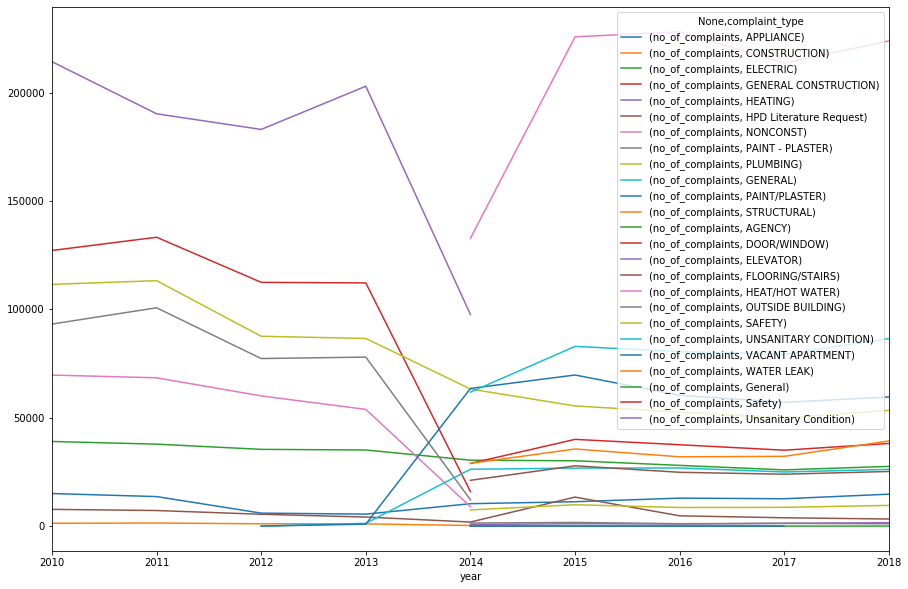

In [14]:
df_count.unstack().plot(kind = 'line', figsize = (15,10))

Looking at the line plot, it is clear that some complaint types have been renamed in 2014. 
They need to be merged for appropriate understanding 

For ease, only the top 5 most frequent unique complaint types will be considered 
Therefore: 

    HEATING and HEAT/HOT WATER
    PAINT - PLASTER and PAINT/PLASTER 
    UNSANITARY CONDITION and Unsanitary Condition
    will be merged and considered alongside GENERAL CONSTRUCTION and PLUMBING

In [11]:
df_complaints = df_311['complaint_type']

df_complaints.replace(to_replace = 'HEATING', value = 'HEAT/HOT WATER', regex = True, inplace = True)
df_complaints.replace(to_replace = 'PAINT - PLASTER', value = 'PAINT/PLASTER', regex = True, inplace = True)
df_complaints.replace(to_replace = 'Unsanitary Condition', value = 'UNSANITARY CONDITION', regex = True, inplace = True)

In [12]:
df_complaints.reset_index()
df_complaints.value_counts()[:5]

HEAT/HOT WATER          1911657
PLUMBING                 673406
PAINT/PLASTER            672333
GENERAL CONSTRUCTION     500863
UNSANITARY CONDITION     391049
Name: complaint_type, dtype: int64

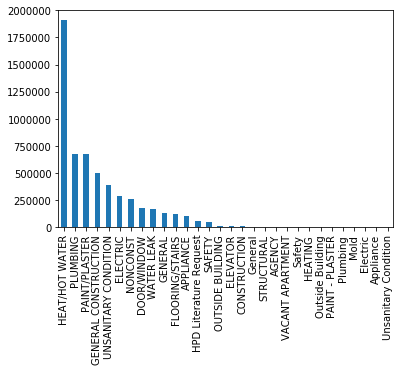

In [15]:
df_complaints.value_counts().plot(kind = 'bar')

In [17]:
#To find most the top (most frequent) complaint type
top_complaint = df_complaints.mode()
print('The final top (most frequent) complaint type is ' + top_complaint[0])

#To find the number of general construction complaints 
gen_cons_count = df_complaints.value_counts()['GENERAL CONSTRUCTION']  
print('The the total number of General Construction complaints is ' + str(gen_cons_count))

The final top (most frequent) complaint type is HEAT/HOT WATER
The the total number of General Construction complaints is 500863


Final Remarks:

Question: 
    
    Which type of complaint should the Department of Housing Preservation and Development of New York City focus on first?

Answer:
    
    Noting the changes to names of some complaint types in 2014 and accordingly going over the data, we can see that complaints surrounding HEATING and HOT WATER are consistently the most frequent each year and hence need attention

Notes:

1. The given API link to the 311 database in the problem statement had a limit of 100,000,000 not 10,000,000 as the prompt demanded 
2. Even so, there were only about 5 million complaints registered to the HPA and created before 31 Dec 2018 according to the csv file I obtained